In [13]:
from __future__ import print_function
import random as rand
import math, random
import matplotlib.pyplot as plt
import networkx as nx
import import_ipynb
import sys
import argparse

In [14]:
pip install parameter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from parameter import *

In [16]:
#parameter setup
if __name__ == "__main__":
    # remove the first argument (kernel)
    #sys.argv.pop(0)
    if len(sys.argv) > 0:
        sys.argv.pop(0)

    parser = argparse.ArgumentParser( prog='my_program',description='scheduling_simulator')

In [17]:
#Simulation setup (Workflow parameter)
parser.add_argument('--num_run', type=int, default=10)
parser.add_argument('--Width', type=int, default=3) 
#max number of parallel tasks or nodes that can exist at a single depth level
parser.add_argument('--Depth', type=int, default=4) # depth of WF process
parser.add_argument('--Max_children', type=int, default=3)
parser.add_argument('--mu', type=int, default=1)
parser.add_argument('--lamb', type=int, default=2)
parser.add_argument('--num_wf', type=int, default=4)
# parser.add_argument('--dag_samples', type=str, default='\wf_samples\cpuOnly_5_15_5' , nargs='+')

#Cluster setup
parser.add_argument('--max_t', type=int, default=60*3)
parser.add_argument('--setupCost', type=float, default=0.2)
parser.add_argument('--num_nodes', type=int, default= [10, 0] , nargs='+')

#Scheduling rules
parser.add_argument('--rule_list', type=str, default=['MC'], nargs='+')#['WCPT','WCPT+MC','MC','SJF','FCFS']#['WCPT','MC','WCPT+MC','SRPT','WCPT+SRPT','SJF','FCFS','EDD','COVERT','ATC']
parser.add_argument('--SwitchThreshold', type=float, default=0.85, help='Threshold for WCPT+SRPT')
parser.add_argument('--SwitchThreshold2_list', type=int, default=[2], nargs='+', help='Threshold for WCPT+MC(k)')

#Task_parallelism
parser.add_argument('--max_tk_parallel_list', type=int, default=[-1,1,2,3,4], nargs='+') #-1: dynamic parallelism
parser.add_argument('--parallel_curve', type=float,  default=[1/N for N in range(1,20)], nargs='+') #[1.00,0.57,0.54,0.52,0.50,0.47,0.45,0.42,0.40,0.38]

#Record

#parser.add_argument('--draw_plot', type=bool, default=False, nargs='+')
parser.add_argument('--draw_plot', type=bool, default=True, nargs='+')
parser.add_argument('--queue_rec_start', type=int, default=10)
parser.add_argument('--bin_size', type=int, default=60, help='cluster utilization record bin size in minute')

    

_StoreAction(option_strings=['--bin_size'], dest='bin_size', nargs=None, const=None, default=60, type=<class 'int'>, choices=None, required=False, help='cluster utilization record bin size in minute', metavar=None)

In [18]:
args = parser.parse_args()

In [19]:
Width = args.Width
Depth = args.Depth
Max_children = args.Max_children
mu = args.mu
Totalsample = args.num_wf #num of WF generating  
Image_pool = ['alpine:3.7','alpine:3.11','alpine:latest','debian:9.4','node:9.1-alpine','docker/whalesay:latest','influxdb:1.2']


# samples from exponential distribution
def interarrival_t(mean):
    return -math.log(1.0 - random.random()) * mean

def generator():
    for count in range(Totalsample):
        data = {'apiVersion': 'argoproj.io/v1alpha1','kind': 'Workflow'}
        data['metadata']= {'generateName': 'sample'+str(count)}
        data['spec'] = {'entrypoint': 'DAG_template'}
       #Define DAG template
        data['spec']['templates'] = [{}]
        data['spec']['templates'][0]['name']= 'DAG_template'
        data['spec']['templates'][0]['dag']= {'tasks':[]}

        taskList = []
        taskIdx = 1
        for d in range(Depth):
            if d == 0:
                r = 1
            else:
                r = rand.randint(1,Width)
            taskList.append(list(range(taskIdx,taskIdx+r)))
            taskIdx = taskIdx+r

        print('taskList',taskList)

        #Determine dependancy
        Dependency = [[] for i in range(taskIdx-1)]
        for i in range(Depth):
            #Nodes at depth level:0 doesn't have any dependency
            if i == 0:
                for j in taskList[i]:
                    pass
            #Nodes at depth level:1+ has at least one dependency on nodes at the upper level
            else:
                for j in taskList[i]:
                    #Choose the number of precedent tasks (at least one, at most min[number of nodes at the upper level, Max_children])
                    num_dependency = rand.randint(1,min(len(taskList[i-1]),Max_children))
                    Dependency[j-1] = rand.sample(taskList[i-1],num_dependency)

        G = nx.DiGraph()
        G.add_edges_from([(j, i+1) for i in range(taskList[-1][-1]) for j in Dependency[i]])
        print(G.edges)
        print('number of operations n: ',len(G.nodes))
        plt.figure(figsize=(4, 4))
        pos = nx.spring_layout(G)
        nx.draw_networkx(G,pos)
        plt.show()

    return G

taskList [[1], [2, 3, 4], [5, 6], [7, 8, 9]]
[(1, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 5), (4, 5), (5, 8), (5, 9), (6, 7), (6, 9)]
number of operations n:  9


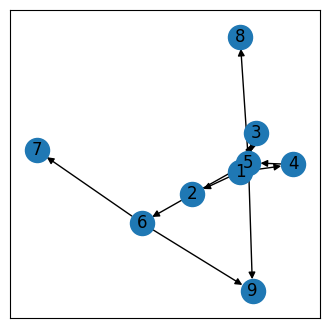

taskList [[1], [2], [3, 4, 5], [6, 7, 8]]
[(1, 2), (2, 3), (2, 4), (2, 5), (3, 6), (3, 7), (3, 8), (4, 6), (4, 8), (5, 8)]
number of operations n:  8


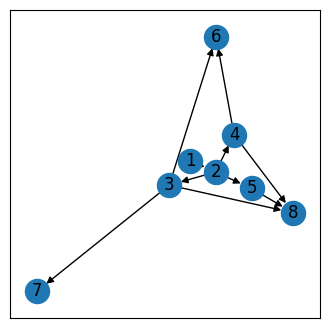

taskList [[1], [2], [3], [4, 5]]
[(1, 2), (2, 3), (3, 4), (3, 5)]
number of operations n:  5


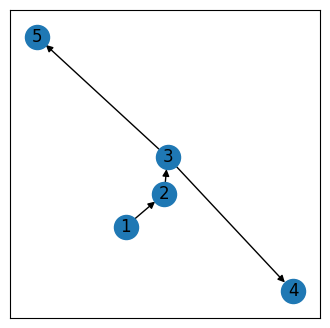

taskList [[1], [2, 3, 4], [5], [6]]
[(1, 2), (1, 3), (1, 4), (4, 5), (5, 6)]
number of operations n:  6


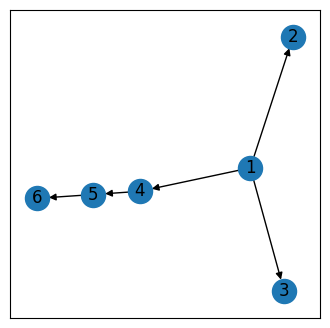

In [20]:
G = generator()

In [ ]:
import json


file_path = "/content/drive/MyDrive/graph.json"

with open(file_path,'w')as f:
    data = {
      'nodes':list(G.nodes),
      'edges':list(G.edges)
  }
    json.dump(data,f)

print("Data saved to file:", file_path)
